In [8]:
# This code is provided for Deep Learning (CS 482/682) Homework 6 practice.
# The network structure is a simplified U-net. You need to finish the last layers
# @Copyright Cong Gao, the Johns Hopkins University, cgao11@jhu.edu
# Modified by Hongtao Wu on Oct 11, 2019 for Fall 2019 Machine Learning: Deep Learning HW6

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import autograd
import numpy as np
import os
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms 
import torchvision.transforms.functional as TF
from PIL import Image
import matplotlib.pyplot as plt


# 1 A

In [9]:
# Functions for adding the convolution layer
def add_conv_stage(dim_in, dim_out, kernel_size=3, stride=1, padding=1, bias=True, useBN=False):
    if useBN:
        # Use batch normalization
        return nn.Sequential(
          nn.Conv2d(dim_in, dim_out, kernel_size=kernel_size, stride=stride, padding=padding, bias=bias),
          nn.BatchNorm2d(dim_out),
          nn.LeakyReLU(0.1),
          nn.Conv2d(dim_out, dim_out, kernel_size=kernel_size, stride=stride, padding=padding, bias=bias),
          nn.BatchNorm2d(dim_out),
          nn.LeakyReLU(0.1)
        )
    else:
        # No batch normalization
        return nn.Sequential(
          nn.Conv2d(dim_in, dim_out, kernel_size=kernel_size, stride=stride, padding=padding, bias=bias),
          nn.ReLU(),
          nn.Conv2d(dim_out, dim_out, kernel_size=kernel_size, stride=stride, padding=padding, bias=bias),
          nn.ReLU()
        )


# Upsampling
def upsample(ch_coarse, ch_fine):
    return nn.Sequential(
        nn.ConvTranspose2d(ch_coarse, ch_fine, 4, 2, 1, bias=False),
        nn.ReLU()
        )


# U-Net
class unet(nn.Module):
    def __init__(self, useBN=False):
        super(unet, self).__init__()
        # Downgrade stages
        self.conv1 = add_conv_stage(3, 32, useBN=useBN)
        self.conv2 = add_conv_stage(32, 64, useBN=useBN)
        self.conv3 = add_conv_stage(64, 128, useBN=useBN)
        self.conv4 = add_conv_stage(128, 256, useBN=useBN)
        # Upgrade stages
        self.conv3m = add_conv_stage(256, 128, useBN=useBN)
        self.conv2m = add_conv_stage(128,  64, useBN=useBN)
        self.conv1m = add_conv_stage( 64,  32, useBN=useBN)
        # Maxpool
        self.max_pool = nn.MaxPool2d(2)
        # Upsample layers
        self.upsample43 = upsample(256, 128)
        self.upsample32 = upsample(128,  64)
        self.upsample21 = upsample(64 ,  32)
        # weight initialization
        # You can have your own weight intialization. This is just an example.
        for m in self.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
                if m.bias is not None:
                    m.bias.data.zero_()

        #TODO: Design your last layer & activations
#         self.convLast = add_conv_stage(32, 8, useBN=useBN, kernel_size=1, padding=0)
        self.convLast = nn.Conv2d(32, 8, kernel_size=1)

    def forward(self, x):
        conv1_out = self.conv1(x)
        conv2_out = self.conv2(self.max_pool(conv1_out))
        conv3_out = self.conv3(self.max_pool(conv2_out))
        conv4_out = self.conv4(self.max_pool(conv3_out))

        conv4m_out_ = torch.cat((self.upsample43(conv4_out), conv3_out), 1)
        conv3m_out  = self.conv3m(conv4m_out_)

        conv3m_out_ = torch.cat((self.upsample32(conv3m_out), conv2_out), 1)
        conv2m_out  = self.conv2m(conv3m_out_)

        conv2m_out_ = torch.cat((self.upsample21(conv2m_out), conv1_out), 1)
        conv1m_out  = self.conv1m(conv2m_out_)

        #TODO: Design your last layer & activations
        convfinal_out = self.convLast(conv1m_out)

        return torch.softmax(convfinal_out, dim=1)

In [10]:
######################## Hyperparameters #################################
# Batch size can be changed if it does not match your memory, please state your batch step_size
# in your report.
train_batch_size = 10
validation_batch_size=10
# Please use this learning rate for Prob1(a) and Prob1(b)
learning_rate = 0.001
# This num_epochs is designed for running to be long enough, you need to manually stop or design
# your early stopping method.
num_epochs = 20

# TODO: Design your own dataset
class ImageDataset(Dataset):
    def __init__(self, input_dir):
        datalist = []
        labellist = []
        onehotlabellist = []
        for folders in os.listdir(input_dir):
            new_dir = os.path.join(input_dir, folders)
            if os.path.isdir(new_dir):
                impath = new_dir+ '/'+folders+'_input.jpg'
                labelpath = new_dir+ '/'+folders+'_mask.png'
                im = Image.open(impath)
                imLab = Image.open(labelpath)
                datalist.append(np.array(im))
                labellist.append(np.array(imLab))
        test = np.transpose(np.array(datalist), (0, 3, 1, 2))
        self.data = torch.from_numpy(np.transpose(np.array(datalist), (0, 3, 1, 2))).type('torch.FloatTensor')
        npLabel = np.array(labellist)
        labels = [0, 32, 64, 96, 128, 160, 192, 224]
        print("start process")
        for i in npLabel:
            imgs = []
            for j in labels:
                mask = self.mask(i, j)
                imgs.append(mask)
            onehotlabellist.append(np.array(imgs))
        print("finish process")
        self.label = torch.from_numpy(np.array(onehotlabellist)).type('torch.FloatTensor')
        
        
    def mask(self, label, val):
        return label & val == val
        
    def __len__ (self):
        return self.data.shape[0]

    def __getitem__(self, idx):
        return self.data[idx], self.label[idx]
    
    def getData(self):
        return self.data, self.label


# TODO: Implement DICE loss
class DICELoss(nn.Module):
#     def __init__(self, input, target):
#         self.forward(input, target)
    def forward(self, input, target):
        smooth = 1.
        iflat = input.view(-1)
        tflat = target.view(-1)
        intersection = (iflat * tflat).sum()
        dice_coeff = ((2. * intersection + smooth) /
                    (iflat.sum() + tflat.sum() + smooth))
        print("Dice Score: ", dice_coeff)
        return 1 - dice_coeff
 

# TODO: Use your designed dataset for dataloading
train_dataset=ImageDataset(input_dir = "./HW6_data/segmentation/train/")
validation_dataset=ImageDataset(input_dir =  "./HW6_data/segmentation/validation/")
model = unet(useBN = True)
model.cuda()
optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

    
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                       batch_size=train_batch_size, 
                                       shuffle=True)
    
validation_loader = torch.utils.data.DataLoader(dataset=validation_dataset, 
                                           batch_size=validation_batch_size, 
                                           shuffle=True)

training_loss = []
validation_loss = []
training_iter = iter(train_loader)
validation_iter = iter(validation_loader)
print("Start Training...")
for epoch in range(num_epochs):

    ########################### Training #####################################
    print("\nEPOCH " +str(epoch+1)+" of "+str(num_epochs)+"\n")
    # TODO: Design your own training section
    model.train()
    torch.set_grad_enabled(True)
    for ind, training_data in enumerate(train_loader):
        x = autograd.Variable(training_data[0]).cuda()
        y = autograd.Variable(training_data[1]).long().cuda()

        optimizer.zero_grad()
        y_hat = model(x)
        train_loss = DICELoss()(y_hat, y)
        train_loss.backward()
        optimizer.step()
        print(train_loss.data)
        training_loss.append(train_loss.data)
    

    ########################### Validation #####################################
    # TODO: Design your own validation section
    print("\nStart Validation...")
    torch.set_grad_enabled(False)
    for ind, valid_data in enumerate(validation_loader):
        x = autograd.Variable(valid_data[0]).cuda()
        y = autograd.Variable(valid_data[1]).long().cuda()
        y_hat = model(x)
        val_loss = DICELoss()(y_hat, y)
        print(val_loss.data)
        validation_loss.append(val_loss.data)
    

start process
finish process
start process
finish process
Start Training...

EPOCH 1 of 20

Dice Score:  tensor(0.1561, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.8439, device='cuda:0')
Dice Score:  tensor(0.1929, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.8071, device='cuda:0')
Dice Score:  tensor(0.2207, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.7793, device='cuda:0')
Dice Score:  tensor(0.2523, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.7477, device='cuda:0')
Dice Score:  tensor(0.2619, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.7381, device='cuda:0')
Dice Score:  tensor(0.2777, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.7223, device='cuda:0')
Dice Score:  tensor(0.2828, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.7172, device='cuda:0')
Dice Score:  tensor(0.2995, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.7005, device='cuda:0')
Dice Score:  tensor(0.3017, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.6983, device='cuda:0')

tensor(0.4209, device='cuda:0')
Dice Score:  tensor(0.5699, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.4301, device='cuda:0')
Dice Score:  tensor(0.5770, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.4230, device='cuda:0')
Dice Score:  tensor(0.5724, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.4276, device='cuda:0')
Dice Score:  tensor(0.5986, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.4014, device='cuda:0')
Dice Score:  tensor(0.5868, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.4132, device='cuda:0')
Dice Score:  tensor(0.5943, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.4057, device='cuda:0')
Dice Score:  tensor(0.6077, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.3923, device='cuda:0')
Dice Score:  tensor(0.6162, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.3838, device='cuda:0')
Dice Score:  tensor(0.6029, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.3971, device='cuda:0')
Dice Score:  tensor(0.5891, device='cuda:0', grad_fn=<DivBa

Dice Score:  tensor(0.7470, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.2530, device='cuda:0')
Dice Score:  tensor(0.7461, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.2539, device='cuda:0')
Dice Score:  tensor(0.7472, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.2528, device='cuda:0')
Dice Score:  tensor(0.7479, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.2521, device='cuda:0')
Dice Score:  tensor(0.7183, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.2817, device='cuda:0')
Dice Score:  tensor(0.7482, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.2518, device='cuda:0')

Start Validation...
Dice Score:  tensor(0.7387, device='cuda:0')
tensor(0.2613, device='cuda:0')
Dice Score:  tensor(0.7263, device='cuda:0')
tensor(0.2737, device='cuda:0')
Dice Score:  tensor(0.7341, device='cuda:0')
tensor(0.2659, device='cuda:0')
Dice Score:  tensor(0.7390, device='cuda:0')
tensor(0.2610, device='cuda:0')
Dice Score:  tensor(0.7336, device='cuda:0')
tensor(0.2664, devic

Dice Score:  tensor(0.7661, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.2339, device='cuda:0')
Dice Score:  tensor(0.7634, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.2366, device='cuda:0')
Dice Score:  tensor(0.7704, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.2296, device='cuda:0')
Dice Score:  tensor(0.7901, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.2099, device='cuda:0')
Dice Score:  tensor(0.7995, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.2005, device='cuda:0')
Dice Score:  tensor(0.7857, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.2143, device='cuda:0')
Dice Score:  tensor(0.7946, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.2054, device='cuda:0')
Dice Score:  tensor(0.8066, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.1934, device='cuda:0')
Dice Score:  tensor(0.7985, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.2015, device='cuda:0')
Dice Score:  tensor(0.8048, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.1952, device=

tensor(0.1804, device='cuda:0')
Dice Score:  tensor(0.7572, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.2428, device='cuda:0')
Dice Score:  tensor(0.8217, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.1783, device='cuda:0')
Dice Score:  tensor(0.8231, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.1769, device='cuda:0')
Dice Score:  tensor(0.8120, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.1880, device='cuda:0')
Dice Score:  tensor(0.8044, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.1956, device='cuda:0')
Dice Score:  tensor(0.7876, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.2124, device='cuda:0')
Dice Score:  tensor(0.8460, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.1540, device='cuda:0')
Dice Score:  tensor(0.7891, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.2109, device='cuda:0')
Dice Score:  tensor(0.8424, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.1576, device='cuda:0')
Dice Score:  tensor(0.7859, device='cuda:0', grad_fn=<DivBa

Dice Score:  tensor(0.8036, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.1964, device='cuda:0')
Dice Score:  tensor(0.8144, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.1856, device='cuda:0')
Dice Score:  tensor(0.8156, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.1844, device='cuda:0')

Start Validation...
Dice Score:  tensor(0.8065, device='cuda:0')
tensor(0.1935, device='cuda:0')
Dice Score:  tensor(0.8062, device='cuda:0')
tensor(0.1938, device='cuda:0')
Dice Score:  tensor(0.8115, device='cuda:0')
tensor(0.1885, device='cuda:0')
Dice Score:  tensor(0.8072, device='cuda:0')
tensor(0.1928, device='cuda:0')
Dice Score:  tensor(0.7968, device='cuda:0')
tensor(0.2032, device='cuda:0')

EPOCH 13 of 20

Dice Score:  tensor(0.8089, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.1911, device='cuda:0')
Dice Score:  tensor(0.8011, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.1989, device='cuda:0')
Dice Score:  tensor(0.8270, device='cuda:0', grad_fn=<DivBackward0>)
ten

Dice Score:  tensor(0.8093, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.1907, device='cuda:0')
Dice Score:  tensor(0.8421, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.1579, device='cuda:0')
Dice Score:  tensor(0.8670, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.1330, device='cuda:0')
Dice Score:  tensor(0.8427, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.1573, device='cuda:0')
Dice Score:  tensor(0.8472, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.1528, device='cuda:0')
Dice Score:  tensor(0.7508, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.2492, device='cuda:0')
Dice Score:  tensor(0.8322, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.1678, device='cuda:0')
Dice Score:  tensor(0.8762, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.1238, device='cuda:0')
Dice Score:  tensor(0.8552, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.1448, device='cuda:0')
Dice Score:  tensor(0.8307, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.1693, device=

tensor(0.1878, device='cuda:0')
Dice Score:  tensor(0.8361, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.1639, device='cuda:0')
Dice Score:  tensor(0.8388, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.1612, device='cuda:0')
Dice Score:  tensor(0.8523, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.1477, device='cuda:0')
Dice Score:  tensor(0.8579, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.1421, device='cuda:0')
Dice Score:  tensor(0.8126, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.1874, device='cuda:0')
Dice Score:  tensor(0.8130, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.1870, device='cuda:0')
Dice Score:  tensor(0.8622, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.1378, device='cuda:0')
Dice Score:  tensor(0.8130, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.1870, device='cuda:0')
Dice Score:  tensor(0.8571, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.1429, device='cuda:0')
Dice Score:  tensor(0.8497, device='cuda:0', grad_fn=<DivBa

Dice Score:  tensor(0.8250, device='cuda:0')
tensor(0.1750, device='cuda:0')
Dice Score:  tensor(0.8414, device='cuda:0')
tensor(0.1586, device='cuda:0')
Dice Score:  tensor(0.8356, device='cuda:0')
tensor(0.1644, device='cuda:0')
Dice Score:  tensor(0.7911, device='cuda:0')
tensor(0.2089, device='cuda:0')
Dice Score:  tensor(0.7986, device='cuda:0')
tensor(0.2014, device='cuda:0')

EPOCH 20 of 20

Dice Score:  tensor(0.8529, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.1471, device='cuda:0')
Dice Score:  tensor(0.8689, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.1311, device='cuda:0')
Dice Score:  tensor(0.8471, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.1529, device='cuda:0')
Dice Score:  tensor(0.8684, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.1316, device='cuda:0')
Dice Score:  tensor(0.8097, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.1903, device='cuda:0')
Dice Score:  tensor(0.8382, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.1618, device='c

In [11]:
# Plot training loss, validation loss
def plot(training_loss, validation_loss):
    plt.figure(300)
    plt.title('Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')   
    plt.plot(training_loss, 'b')
    plt.figure(400)
    plt.title('Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')   
    plt.plot(validation_loss, 'b')
    plt.show()

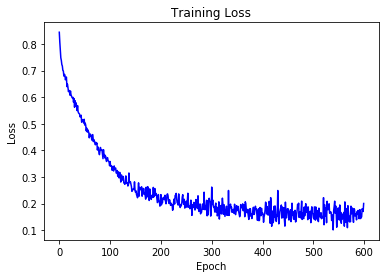

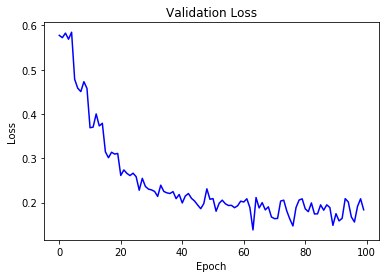

In [12]:
plot(training_loss, validation_loss)

modelweights = model.state_dict()
# del model
del train_loader
del validation_loader
torch.cuda.empty_cache()
model = unet(useBN=True).cuda()
model.load_state_dict(modelweights)

In [13]:
test_dataset=ImageDataset(input_dir = "./HW6_data/segmentation/test/")    
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                       batch_size=10)
def dice_coeff(input, target):
    smooth = 1.
    iflat = input.view(-1)
    tflat = target.view(-1)
    intersection = (iflat * tflat).sum()
    dice_coeff = ((2. * intersection + smooth) /
                (iflat.sum() + tflat.sum() + smooth))
    return dice_coeff
    
for ind, data in enumerate(test_loader):
    model.eval()
    x = autograd.Variable(data[0]).cuda()
    y = autograd.Variable(data[1]).long().cuda()
    y_hat = model(x)
#     plt.figure(100)
#     plt.imshow(y_hat[0][8].cpu().detach())
#     plt.figure(200)
#     plt.imshow(y[0][8].cpu().detach())
    acc = dice_coeff(y_hat, y)
    print("Accuracy: ", acc, ind);
    
    

start process
finish process
Accuracy:  tensor(0.7941, device='cuda:0') 0
Accuracy:  tensor(0.7905, device='cuda:0') 1
Accuracy:  tensor(0.8114, device='cuda:0') 2
Accuracy:  tensor(0.8455, device='cuda:0') 3
Accuracy:  tensor(0.8312, device='cuda:0') 4


# 1 B Data Augmentation, 1 C training

In [14]:
import random
######################## Hyperparameters #################################
# Batch size can be changed if it does not match your memory, please state your batch step_size
# in your report.
train_batch_size = 10
validation_batch_size=10
# Please use this learning rate for Prob1(a) and Prob1(b)
learning_rate = 0.1
# This num_epochs is designed for running to be long enough, you need to manually stop or design
# your early stopping method.
num_epochs = 10

# TODO: Design your own dataset
class ImageDatasetAugmentation(Dataset):
    def __init__(self, input_dir, transform=False):
        datalist = []
        labellist = []
        onehotlabellist = []
        for folders in os.listdir(input_dir):
            new_dir = os.path.join(input_dir, folders)
            if os.path.isdir(new_dir):
                impath = new_dir+ '/'+folders+'_input.jpg'
                labelpath = new_dir+ '/'+folders+'_mask.png'
                im = Image.open(impath)
                imLab = Image.open(labelpath)
                datalist.append(np.array(im))
                labellist.append(np.array(imLab))
        test = np.transpose(np.array(datalist), (0, 3, 1, 2))
        self.data = torch.from_numpy(np.transpose(np.array(datalist), (0, 3, 1, 2))).type('torch.FloatTensor')
        npLabel = np.array(labellist)
        labels = [0, 32, 64, 96, 128, 160, 192, 224]
        print("start process")
        for i in npLabel:
            imgs = []
            for j in labels:
                mask = self.mask(i, j)
                imgs.append(mask)
            onehotlabellist.append(np.array(imgs))
        print("finish process")
        self.label = torch.from_numpy(np.array(onehotlabellist)).type('torch.FloatTensor')
        self.transform = transform
        
    def mask(self, label, val):
        return label & val == val
        
    def __len__ (self):
        return self.data.shape[0]

    def __getitem__(self, idx):
        data = self.data[idx]
        label = self.label[idx]
        # Vertical Flip
        if self.transform:
            if random.random() > 0.9:
                if random.random() > 0.7:
                    data = data.permute(1, 2, 0)
                    data = transforms.ToTensor()(TF.vflip(transforms.ToPILImage()(np.uint8(data))))
                    for i in range(label.shape[0]):
                        label[i] = transforms.ToTensor()(TF.vflip(transforms.ToPILImage()(np.uint8(label[i]))))
                # Horizontal Flip
                if random.random() > 0.7:
                    data = data.permute(1, 2, 0)
                    data = transforms.ToTensor()(TF.hflip(transforms.ToPILImage()(np.uint8(data))))
                    for i in range(label.shape[0]):
                        label[i] = transforms.ToTensor()(TF.hflip(transforms.ToPILImage()(np.uint8(label[i]))))

                # Change Brightness, Hue, Saturation
                if random.random() > 0.7:
                    data = data.permute(1, 2, 0)
                    data = transforms.ToTensor()(transforms.ColorJitter(brightness=random.uniform(0, 1), hue=random.uniform(0, 0.5), 
                                                                        saturation=random.uniform(0, 1))
                                                 (transforms.ToPILImage()(np.uint8(data))))  
        return data, label


# TODO: Implement DICE loss
class DICELoss(nn.Module):
#     def __init__(self, input, target):
#         self.forward(input, target)
    def forward(self, input, target):
        smooth = 1.
        iflat = input.view(-1)
        tflat = target.view(-1)
        intersection = (iflat * tflat).sum()
        dice_coeff = ((2. * intersection + smooth) /
                    (iflat.sum() + tflat.sum() + smooth))
        print("Dice Score: ", dice_coeff)
        return 1 - dice_coeff
 

# TODO: Use your designed dataset for dataloading
train_dataset=ImageDatasetAugmentation(input_dir = "./HW6_data/segmentation/train/", transform=True)
validation_dataset=ImageDatasetAugmentation(input_dir =  "./HW6_data/segmentation/validation/")
model_aug = unet(useBN = True)
model_aug.cuda()
optimizer = torch.optim.Adam(model_aug.parameters(),lr=learning_rate)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

    
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                       batch_size=train_batch_size, 
                                       shuffle=True)
    
validation_loader = torch.utils.data.DataLoader(dataset=validation_dataset, 
                                           batch_size=validation_batch_size, 
                                           shuffle=True)

training_loss = []
validation_loss = []
training_iter = iter(train_loader)
validation_iter = iter(validation_loader)
print("Start Training...")
for epoch in range(num_epochs):

    ########################### Training #####################################
    print("\nEPOCH " +str(epoch+1)+" of "+str(num_epochs)+"\n")
    # TODO: Design your own training section
    model_aug.train()
    torch.set_grad_enabled(True)
    for ind, training_data in enumerate(train_loader):
        x = autograd.Variable(training_data[0]).cuda()
        y = autograd.Variable(training_data[1]).long().cuda()

        optimizer.zero_grad()
        y_hat = model_aug(x)
        train_loss = DICELoss()(y_hat, y)
        train_loss.backward()
        optimizer.step()
        print(train_loss.data)
        training_loss.append(train_loss.data)
    

    ########################### Validation #####################################
    # TODO: Design your own validation section
    print("\nStart Validation...")
    torch.set_grad_enabled(False)
    for ind, valid_data in enumerate(validation_loader):
        x = autograd.Variable(valid_data[0]).cuda()
        y = autograd.Variable(valid_data[1]).long().cuda()
        y_hat = model_aug(x)
        val_loss = DICELoss()(y_hat, y)
        print(val_loss.data)
        validation_loss.append(val_loss.data)
    

start process
finish process
start process
finish process
Start Training...

EPOCH 1 of 10

Dice Score:  tensor(0.0926, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.9074, device='cuda:0')
Dice Score:  tensor(0.2596, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.7404, device='cuda:0')
Dice Score:  tensor(0.5152, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.4848, device='cuda:0')
Dice Score:  tensor(0.8322, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.1678, device='cuda:0')
Dice Score:  tensor(0.8387, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.1613, device='cuda:0')
Dice Score:  tensor(0.8100, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.1900, device='cuda:0')
Dice Score:  tensor(0.8049, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.1951, device='cuda:0')
Dice Score:  tensor(0.8321, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.1679, device='cuda:0')
Dice Score:  tensor(0.8018, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.1982, device='cuda:0')

tensor(0.2303, device='cuda:0')
Dice Score:  tensor(0.7041, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.2959, device='cuda:0')
Dice Score:  tensor(0.7242, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.2758, device='cuda:0')
Dice Score:  tensor(0.7967, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.2033, device='cuda:0')
Dice Score:  tensor(0.8417, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.1583, device='cuda:0')
Dice Score:  tensor(0.8126, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.1874, device='cuda:0')
Dice Score:  tensor(0.6067, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.3933, device='cuda:0')
Dice Score:  tensor(0.7922, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.2078, device='cuda:0')
Dice Score:  tensor(0.6332, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.3668, device='cuda:0')
Dice Score:  tensor(0.9160, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0840, device='cuda:0')
Dice Score:  tensor(0.7503, device='cuda:0', grad_fn=<DivBa

Dice Score:  tensor(0.7154, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.2846, device='cuda:0')
Dice Score:  tensor(0.7897, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.2103, device='cuda:0')
Dice Score:  tensor(0.6297, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.3703, device='cuda:0')
Dice Score:  tensor(0.6735, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.3265, device='cuda:0')
Dice Score:  tensor(0.8265, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.1735, device='cuda:0')
Dice Score:  tensor(0.7661, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.2339, device='cuda:0')

Start Validation...
Dice Score:  tensor(0.8260, device='cuda:0')
tensor(0.1740, device='cuda:0')
Dice Score:  tensor(0.7918, device='cuda:0')
tensor(0.2082, device='cuda:0')
Dice Score:  tensor(0.8417, device='cuda:0')
tensor(0.1583, device='cuda:0')
Dice Score:  tensor(0.8308, device='cuda:0')
tensor(0.1692, device='cuda:0')
Dice Score:  tensor(0.8150, device='cuda:0')
tensor(0.1850, devic

Dice Score:  tensor(0.5862, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.4138, device='cuda:0')
Dice Score:  tensor(0.7122, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.2878, device='cuda:0')
Dice Score:  tensor(0.2994, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.7006, device='cuda:0')
Dice Score:  tensor(0.8037, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.1963, device='cuda:0')
Dice Score:  tensor(0.7899, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.2101, device='cuda:0')
Dice Score:  tensor(0.5728, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.4272, device='cuda:0')
Dice Score:  tensor(0.6686, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.3314, device='cuda:0')
Dice Score:  tensor(0.6064, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.3936, device='cuda:0')
Dice Score:  tensor(0.7451, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.2549, device='cuda:0')
Dice Score:  tensor(0.6731, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.3269, device=

tensor(0.5755, device='cuda:0')
Dice Score:  tensor(0.1733, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.8267, device='cuda:0')
Dice Score:  tensor(0.6742, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.3258, device='cuda:0')
Dice Score:  tensor(0.8003, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.1997, device='cuda:0')
Dice Score:  tensor(0.5270, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.4730, device='cuda:0')
Dice Score:  tensor(0.5038, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.4962, device='cuda:0')
Dice Score:  tensor(0.7167, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.2833, device='cuda:0')
Dice Score:  tensor(0.5777, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.4223, device='cuda:0')
Dice Score:  tensor(0.5834, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.4166, device='cuda:0')
Dice Score:  tensor(0.7121, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.2879, device='cuda:0')
Dice Score:  tensor(0.7756, device='cuda:0', grad_fn=<DivBa

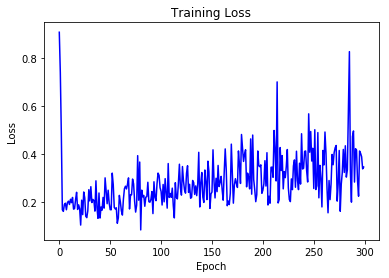

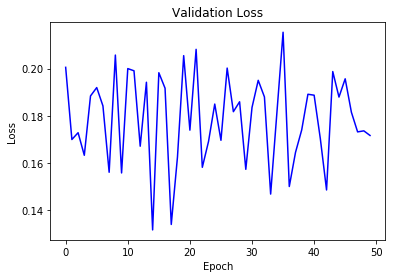

In [15]:
plot(training_loss, validation_loss)

In [16]:
test_dataset=ImageDatasetAugmentation(input_dir = "./HW6_data/segmentation/test/")    
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                       batch_size=10)
def dice_coeff(input, target):
    smooth = 1.
    iflat = input.view(-1)
    tflat = target.view(-1)
    intersection = (iflat * tflat).sum()
    dice_coeff = ((2. * intersection + smooth) /
                (iflat.sum() + tflat.sum() + smooth))
    return dice_coeff
    
for ind, data in enumerate(test_loader):
    model_aug.eval()
    x = autograd.Variable(data[0]).cuda()
    y = autograd.Variable(data[1]).long().cuda()
    y_hat = model_aug(x)
#     plt.figure(100)
#     plt.imshow(y_hat[0][8].cpu().detach())
#     plt.figure(200)
#     plt.imshow(y[0][8].cpu().detach())
    acc = dice_coeff(y_hat, y)
    print("Accuracy: ", acc, ind);

start process
finish process
Accuracy:  tensor(0.7965, device='cuda:0') 0
Accuracy:  tensor(0.7929, device='cuda:0') 1
Accuracy:  tensor(0.8139, device='cuda:0') 2
Accuracy:  tensor(0.8479, device='cuda:0') 3
Accuracy:  tensor(0.8360, device='cuda:0') 4
